Loaded: pup2_good / brush_ipsi
Filtered to 28 good/mua units.


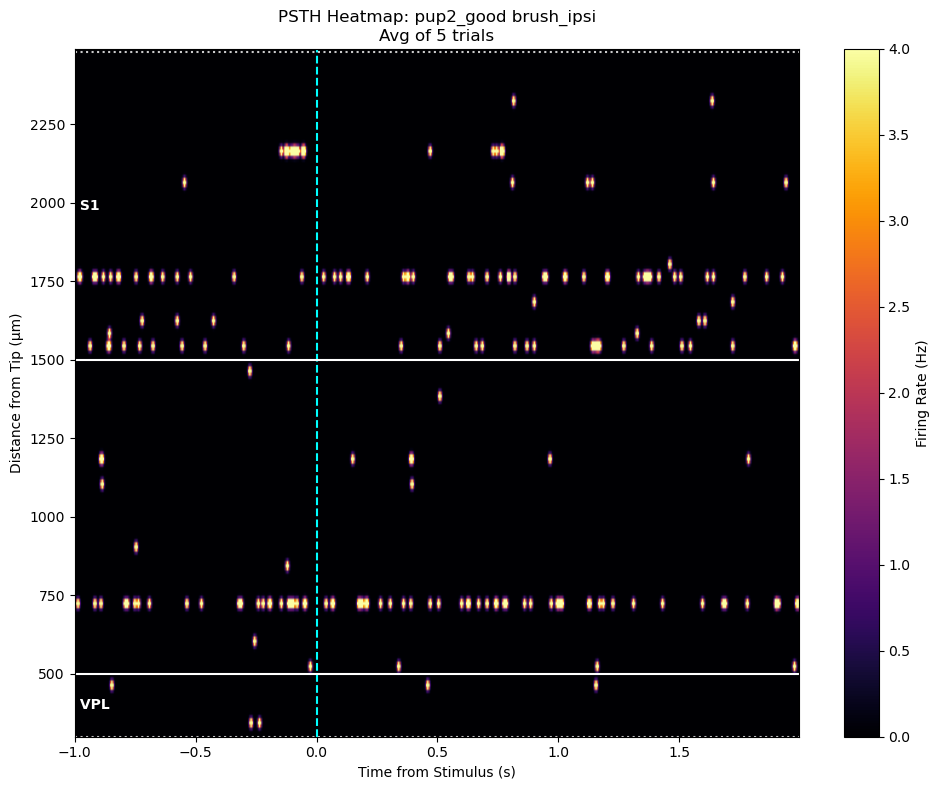

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from pathlib import Path
from scipy.ndimage import gaussian_filter

# ===== SESSION SELECTION =====
SESSION = "pup2_good"         # animal id
STIM = "brush_ipsi"       # stim type
# =============================

# --- 1. YOUR LOADING BLOCK (Standard) ---
table_path = Path("data/sessions_local.csv") if Path("data/sessions_local.csv").exists() else Path("data/sessions.csv")
sessions = pd.read_csv(table_path, sep=',') 

# Select row
row = sessions.loc[(sessions['session'].str.lower() == SESSION.lower()) & 
                   (sessions['stim'].str.lower() == STIM.lower())]
if row.empty:
    raise ValueError(f"No row found for session={SESSION}, stim={STIM}")
row = row.iloc[0]

# Metadata
phy_dir = Path(row['phy_dir'])
lfp_dir  = Path(row['lfp_dir'])
age = str(row['age']).strip()
S1_upper_um  = float(row['s1_upper_um'])
S1_lower_um  = float(row['s1_lower_um'])
VPL_upper_um = float(row['vpl_upper_um'])
VPL_lower_um = float(row['vpl_lower_um'])
tip_dv_mm = float(row['tip_dv_mm']) # Not used for depth calculation anymore
FS_AP = 30000

print(f"Loaded: {SESSION} / {STIM}")

# --- 2. HEATMAP CONFIGURATION ---
PSTH_WINDOW = (-1.0, 2.0)   # Seconds
BIN_TIME = 0.005            # 50ms bins
BIN_DEPTH = 10              # 20um bins
MIN_DEPTH_VIEW = 300        # Start plotting at this depth (remove bottom channels)
MAX_DEPTH_VIEW = 2500       # Plot up to this depth
VMAX_HZ = 4

# --- 3. PROCESSING LOGIC (RAW DEPTH) ---
def generate_heatmap():
    # A. Load Onset Times
    onset_file = Path(f"results/summaries/{SESSION}_{STIM}_onsets.txt")
    if not onset_file.exists():
        print(f"❌ Missing onset file: {onset_file}")
        return None, None, None
    onsets = np.loadtxt(onset_file)
    if onsets.ndim == 0: onsets = [onsets]
    
    # B. Load Kilosort Data
    st = np.load(phy_dir / 'spike_times.npy').flatten() / FS_AP
    sc = np.load(phy_dir / 'spike_clusters.npy').flatten()
    coords = np.load(phy_dir / 'channel_positions.npy')
    templates = np.load(phy_dir / 'templates.npy')
    spike_templates = np.load(phy_dir / 'spike_templates.npy').flatten()

    # C. Filter "Good" Units
    ks_path = phy_dir / 'cluster_group.tsv'
    if not ks_path.exists(): ks_path = phy_dir / 'cluster_KSLabel.tsv'
    good_ids = []
    if ks_path.exists():
        try:
            df_ks = pd.read_csv(ks_path, sep='\t')
            col = 'KSLabel' if 'KSLabel' in df_ks.columns else 'group'
            good_ids = set(df_ks[df_ks[col].isin(['good', 'mua'])]['cluster_id'].values)
        except: pass
    
    if len(good_ids) > 0:
        mask_good = np.isin(sc, list(good_ids))
        st = st[mask_good]
        spike_templates = spike_templates[mask_good]
        print(f"Filtered to {len(good_ids)} good/mua units.")

    # D. Map Spikes to Depth (RAW)
    template_peaks = np.max(np.abs(templates), axis=1) 
    template_max_chans = np.argmax(template_peaks, axis=1)
    
    # Use RAW distance from tip (0 = Tip)
    spike_depths = coords[template_max_chans[spike_templates], 1]
    
    # E. Build Histogram
    t_bins = np.arange(PSTH_WINDOW[0], PSTH_WINDOW[1], BIN_TIME)
    
    # <--- UPDATED: Bins now start at MIN_DEPTH_VIEW instead of 0
    d_bins = np.arange(MIN_DEPTH_VIEW, MAX_DEPTH_VIEW, BIN_DEPTH)
    
    total_heatmap = np.zeros((len(t_bins)-1, len(d_bins)-1))

    for onset in onsets:
        t_start, t_end = onset + PSTH_WINDOW[0], onset + PSTH_WINDOW[1]
        
        idx_start = np.searchsorted(st, t_start)
        idx_end = np.searchsorted(st, t_end)
        
        st_win = st[idx_start:idx_end]
        sd_win = spike_depths[idx_start:idx_end]
        
        if len(st_win) == 0: continue

        aligned_times = st_win - onset
        
        # Add to histogram
        # Spikes outside (MIN_DEPTH_VIEW, MAX_DEPTH_VIEW) are automatically ignored by histogram2d
        H, _, _ = np.histogram2d(aligned_times, sd_win, bins=[t_bins, d_bins])
        total_heatmap += H

    # Average (Hz)
    avg_heatmap = (total_heatmap / len(onsets)) / BIN_TIME
    return avg_heatmap, t_bins, d_bins

# --- 4. EXECUTION & PLOTTING ---
heatmap, t_bins, d_bins = generate_heatmap()

if heatmap is not None:
    plt.figure(figsize=(10, 8))
    
    h_smooth = gaussian_filter(heatmap, sigma=(1, 1))
    
    # origin='lower' puts 0 (Tip) at the bottom
    # extent uses d_bins[0] (which is now MIN_DEPTH_VIEW) and d_bins[-1] (MAX_DEPTH_VIEW)
    plt.imshow(h_smooth.T, aspect='auto', cmap='inferno', origin='lower',
               extent=[t_bins[0], t_bins[-1], d_bins[0], d_bins[-1]],
               vmax=VMAX_HZ)
    
    cb = plt.colorbar()
    cb.set_label("Firing Rate (Hz)")
    
    plt.axvline(0, color='cyan', linestyle='--', linewidth=1.5, label='Stimulus')
    
    # Overlay Anatomy Bands (using Raw Values from CSV)
    # S1
    if not np.isnan(S1_upper_um) and not np.isnan(S1_lower_um):
        plt.axhline(S1_upper_um, color='white', linestyle=':', alpha=0.8)
        plt.axhline(S1_lower_um, color='white', linestyle='-', alpha=1.0)
        plt.text(PSTH_WINDOW[0], (S1_upper_um + S1_lower_um)/2, ' S1', color='white', va='center', fontweight='bold')

    # VPL
    if not np.isnan(VPL_upper_um) and not np.isnan(VPL_lower_um):
        plt.axhline(VPL_upper_um, color='white', linestyle='-', alpha=1.0)
        plt.axhline(VPL_lower_um, color='white', linestyle=':', alpha=0.8)
        plt.text(PSTH_WINDOW[0], (VPL_upper_um + VPL_lower_um)/2, ' VPL', color='white', va='center', fontweight='bold')

    plt.xlabel("Time from Stimulus (s)")
    plt.ylabel("Distance from Tip (µm)")
    plt.title(f"PSTH Heatmap: {SESSION} {STIM}\nAvg of {len(np.loadtxt(f'results/summaries/{SESSION}_{STIM}_onsets.txt'))} trials")
    plt.tight_layout()
    plt.show()

Filtered to 28 good/mua units.
DATA STATISTICS for pup2_good
----------------------------------------
True Max Firing Rate:   16.60 Hz
Robust Max (99.9%):     7.23 Hz
Suggested VMAX_HZ:      8


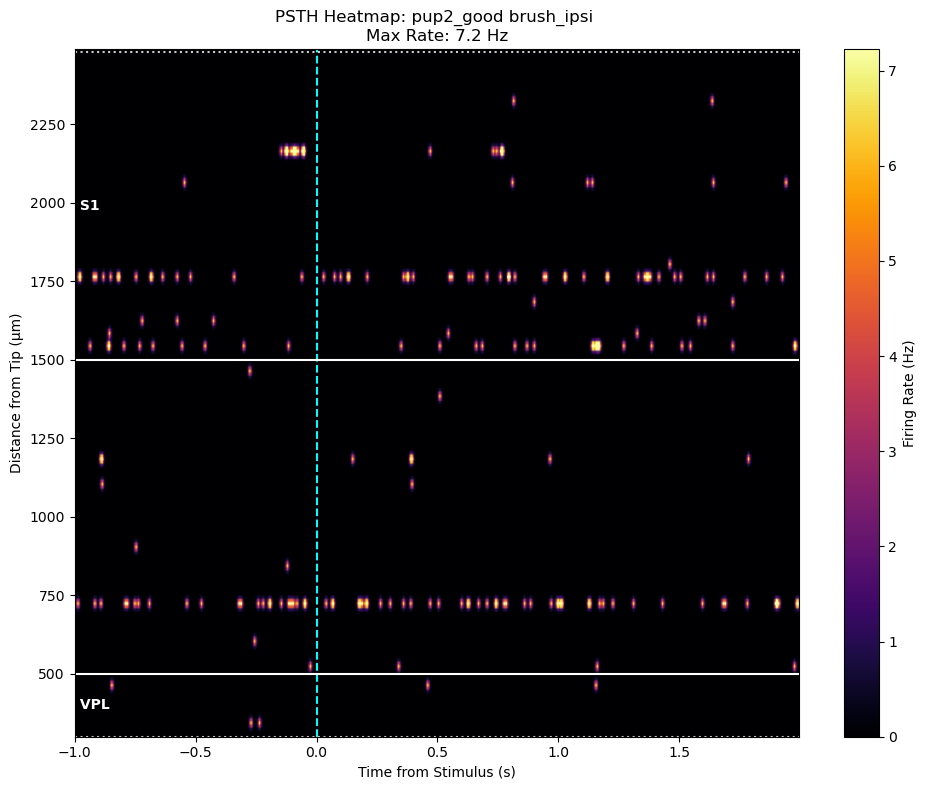

In [33]:
# --- 4. EXECUTION & STATS ---
heatmap, t_bins, d_bins = generate_heatmap()

if heatmap is not None:
    # 1. Smooth the data (same as you do for plotting)
    h_smooth = gaussian_filter(heatmap, sigma=(1, 1))
    
    # 2. Calculate Stats
    true_max = np.max(h_smooth)
    robust_max = np.percentile(h_smooth, 99.9) # Ignores top 0.1% outliers
    
    print(f"========================================")
    print(f"DATA STATISTICS for {SESSION}")
    print(f"----------------------------------------")
    print(f"True Max Firing Rate:   {true_max:.2f} Hz")
    print(f"Robust Max (99.9%):     {robust_max:.2f} Hz")
    print(f"Suggested VMAX_HZ:      {int(np.ceil(robust_max))}")
    print(f"========================================")

    # 3. Plotting
    plt.figure(figsize=(10, 8))
    
    # Use the calculated robust_max for the plot automatically
    plt.imshow(h_smooth.T, aspect='auto', cmap='inferno', origin='lower',
               extent=[t_bins[0], t_bins[-1], d_bins[0], d_bins[-1]],
               vmax=robust_max) # <--- UPDATED THIS
    
    cb = plt.colorbar()
    cb.set_label("Firing Rate (Hz)")
    
    plt.axvline(0, color='cyan', linestyle='--', linewidth=1.5, label='Stimulus')
    
    # Overlay Anatomy
    if not np.isnan(S1_upper_um) and not np.isnan(S1_lower_um):
        plt.axhline(S1_upper_um, color='white', linestyle=':', alpha=0.8)
        plt.axhline(S1_lower_um, color='white', linestyle='-', alpha=1.0)
        plt.text(PSTH_WINDOW[0], (S1_upper_um + S1_lower_um)/2, ' S1', color='white', va='center', fontweight='bold')

    if not np.isnan(VPL_upper_um) and not np.isnan(VPL_lower_um):
        plt.axhline(VPL_upper_um, color='white', linestyle='-', alpha=1.0)
        plt.axhline(VPL_lower_um, color='white', linestyle=':', alpha=0.8)
        plt.text(PSTH_WINDOW[0], (VPL_upper_um + VPL_lower_um)/2, ' VPL', color='white', va='center', fontweight='bold')

    plt.xlabel("Time from Stimulus (s)")
    plt.ylabel("Distance from Tip (µm)")
    plt.title(f"PSTH Heatmap: {SESSION} {STIM} \nMax Rate: {robust_max:.1f} Hz")
    plt.tight_layout()
    plt.show()

Loaded: pup2_good / brush_ipsi
Filtered to 28 good/mua units.
Removed 2 spikes found in ignored bands: [(500, 540)]
Auto-calculated VMAX: 7.23 Hz


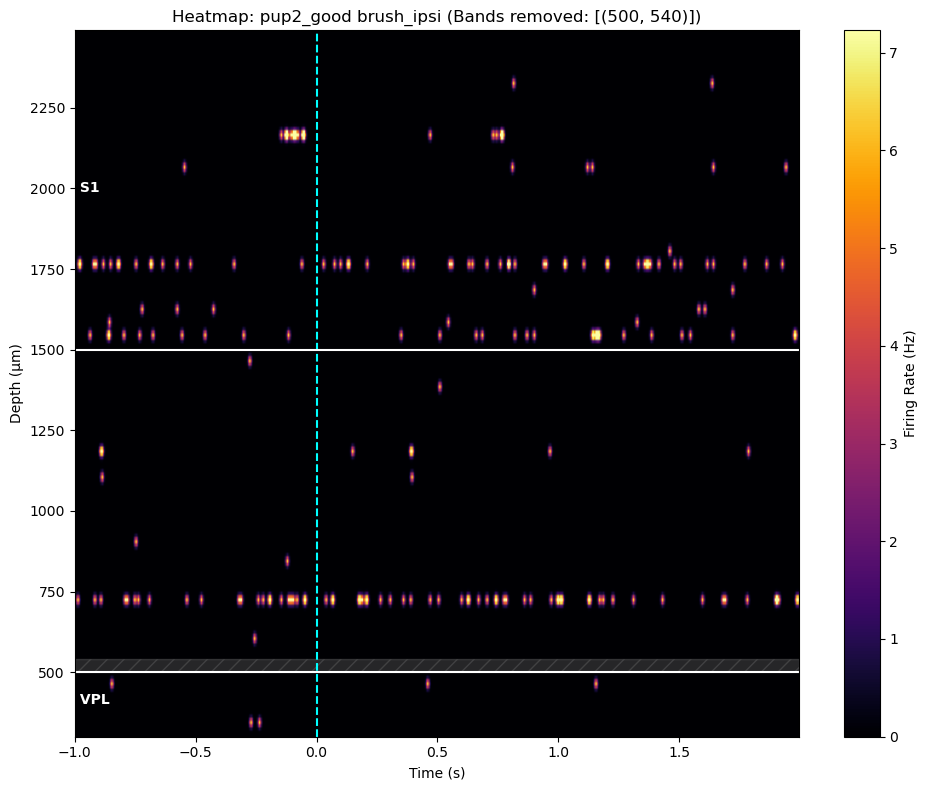

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from pathlib import Path
from scipy.ndimage import gaussian_filter

# --- 1. YOUR LOADING BLOCK ---
table_path = Path("data/sessions.csv")
sessions = pd.read_csv(table_path, sep=',') 

row = sessions.loc[(sessions['session'].str.lower() == SESSION.lower()) & 
                   (sessions['stim'].str.lower() == STIM.lower())]
if row.empty:
    raise ValueError(f"No row found for session={SESSION}, stim={STIM}")
row = row.iloc[0]

phy_dir = Path(row['phy_dir'])
S1_upper_um  = float(row['s1_upper_um'])
S1_lower_um  = float(row['s1_lower_um'])
VPL_upper_um = float(row['vpl_upper_um'])
VPL_lower_um = float(row['vpl_lower_um'])
FS_AP = 30000

print(f"Loaded: {SESSION} / {STIM}")

# *** NEW: Define bands to remove (Low, High) in microns ***
# Example: Remove a noisy band between 1200um and 1400um
IGNORE_BANDS = [
    (500, 540),  
    # (1800, 1850), # You can add multiple bands
]

# --- 3. PROCESSING LOGIC ---
def generate_heatmap():
    # A. Load Onsets
    onset_file = Path(f"results/summaries/{SESSION}_{STIM}_onsets.txt")
    if not onset_file.exists(): return None, None, None
    onsets = np.loadtxt(onset_file)
    if onsets.ndim == 0: onsets = [onsets]
    
    # B. Load Kilosort Data
    st = np.load(phy_dir / 'spike_times.npy').flatten() / FS_AP
    sc = np.load(phy_dir / 'spike_clusters.npy').flatten()
    coords = np.load(phy_dir / 'channel_positions.npy')
    templates = np.load(phy_dir / 'templates.npy')
    spike_templates = np.load(phy_dir / 'spike_templates.npy').flatten()

    # C. Filter Good Units
    ks_path = phy_dir / 'cluster_group.tsv'
    if not ks_path.exists(): ks_path = phy_dir / 'cluster_KSLabel.tsv'
    good_ids = []
    if ks_path.exists():
        try:
            df_ks = pd.read_csv(ks_path, sep='\t')
            col = 'KSLabel' if 'KSLabel' in df_ks.columns else 'group'
            good_ids = set(df_ks[df_ks[col].isin(['good', 'mua'])]['cluster_id'].values)
        except: pass
    
    if len(good_ids) > 0:
        mask_good = np.isin(sc, list(good_ids))
        st = st[mask_good]
        spike_templates = spike_templates[mask_good]
        print(f"Filtered to {len(good_ids)} good/mua units.")

    # D. Map Spikes to Depth
    template_peaks = np.max(np.abs(templates), axis=1) 
    template_max_chans = np.argmax(template_peaks, axis=1)
    spike_depths = coords[template_max_chans[spike_templates], 1]
    
    # *** E. NEW: Remove Noisy Bands ***
    if IGNORE_BANDS:
        mask_clean = np.ones(len(spike_depths), dtype=bool)
        for (low, high) in IGNORE_BANDS:
            # Mark spikes false if they are inside the band
            mask_clean &= ~((spike_depths >= low) & (spike_depths <= high))
        
        # Apply mask
        st = st[mask_clean]
        spike_depths = spike_depths[mask_clean]
        print(f"Removed {np.sum(~mask_clean)} spikes found in ignored bands: {IGNORE_BANDS}")

    # F. Build Histogram
    t_bins = np.arange(PSTH_WINDOW[0], PSTH_WINDOW[1], BIN_TIME)
    d_bins = np.arange(MIN_DEPTH_VIEW, MAX_DEPTH_VIEW, BIN_DEPTH)
    
    total_heatmap = np.zeros((len(t_bins)-1, len(d_bins)-1))

    for onset in onsets:
        t_start, t_end = onset + PSTH_WINDOW[0], onset + PSTH_WINDOW[1]
        
        idx_start = np.searchsorted(st, t_start)
        idx_end = np.searchsorted(st, t_end)
        
        st_win = st[idx_start:idx_end]
        sd_win = spike_depths[idx_start:idx_end]
        
        if len(st_win) == 0: continue

        aligned_times = st_win - onset
        H, _, _ = np.histogram2d(aligned_times, sd_win, bins=[t_bins, d_bins])
        total_heatmap += H

    return (total_heatmap / len(onsets)) / BIN_TIME, t_bins, d_bins

# --- 4. EXECUTION & AUTO-SCALING ---
heatmap, t_bins, d_bins = generate_heatmap()

if heatmap is not None:
    # Smooth
    h_smooth = gaussian_filter(heatmap, sigma=(1, 1))
    
    # Auto-calculate Vmax (Robust)
    robust_max = np.percentile(h_smooth, 99.9)
    print(f"Auto-calculated VMAX: {robust_max:.2f} Hz")

    plt.figure(figsize=(10, 8))
    plt.imshow(h_smooth.T, aspect='auto', cmap='inferno', origin='lower',
               extent=[t_bins[0], t_bins[-1], d_bins[0], d_bins[-1]],
               vmax=robust_max) # Uses the auto-calculated max
    
    plt.colorbar(label="Firing Rate (Hz)")
    plt.axvline(0, color='cyan', linestyle='--', linewidth=1.5)

    # Visualize the removed bands (Optional: draws grey bars where data was removed)
    for (low, high) in IGNORE_BANDS:
        plt.axhspan(low, high, color='grey', alpha=0.3, hatch='//')

    # Anatomy overlay
    if not np.isnan(S1_upper_um) and not np.isnan(S1_lower_um):
        plt.axhline(S1_lower_um, color='white')
        plt.text(PSTH_WINDOW[0], (S1_upper_um + S1_lower_um)/2, ' S1', color='white', fontweight='bold')
    if not np.isnan(VPL_upper_um) and not np.isnan(VPL_lower_um):
        plt.axhline(VPL_upper_um, color='white')
        plt.text(PSTH_WINDOW[0], (VPL_upper_um + VPL_lower_um)/2, ' VPL', color='white', fontweight='bold')

    plt.xlabel("Time (s)")
    plt.ylabel("Depth (µm)")
    plt.title(f"Heatmap: {SESSION} {STIM} (Bands removed: {IGNORE_BANDS})")
    plt.tight_layout()
    plt.show()